# Carregando bibliotecas

In [27]:
# General Libs
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.xception  import Xception, preprocess_input
from tensorflow.keras.models import load_model

from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Variáveis necessárias

In [19]:
# Variáveis
im_shape = (250,250)

base_dir = './dataset/dataset'
train_dir = './dataset/train'
test_dir = './dataset/test'
TRAINING_DIR = '.\\dataset\\train'
TEST_DIR = '.\\dataset\\test'

seed = 20

EPOCHS = 1200
PATIENCE = 100
BATCH_SIZE = 16
LAST_CONV_NAME_LAYER='conv_last'
LAST_CONV_NAME_LAYER_TF='block14_sepconv2_act'

# Separando dataset

In [40]:
# Verificar se as imagens podem ser lidas
def verify_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Tenta abrir o arquivo como imagem
                img.verify()  # Verifica se é uma imagem válida
            except (IOError, SyntaxError) as e:
                print(f"Arquivo inválido detectado: {file_path}, erro: {e}")

# Verificar imagens no diretório de treino
verify_images(base_dir)

In [41]:
# Normalizar os caminhos
base_dir = os.path.normpath(base_dir)
train_dir = os.path.normpath(train_dir)
test_dir = os.path.normpath(test_dir)

# Criação das pastas de treino, validação e teste
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [42]:
# Processamento de todas as imagens nas subpastas
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    folder_path = os.path.normpath(folder_path) 
    
    
    train_dir_aux = os.path.join(train_dir, folder)
    train_dir_aux = os.path.normpath(train_dir_aux)
    
    test_dir_aux = os.path.join(test_dir, folder)
    test_dir_aux = os.path.normpath(test_dir_aux)
    
    os.makedirs(test_dir_aux, exist_ok=True)
    os.makedirs(train_dir_aux, exist_ok=True)
    
    
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        
        # Divide em treino (70%), teste (30%)
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        
        # Mover imagens de treino
        for image_file in train_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(train_dir_aux, image_file))
        
        # Mover imagens de teste
        for image_file in test_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(test_dir_aux, image_file))

print("Processo de divisão e aumento de dados completo!")

Processo de divisão e aumento de dados completo!


# Data Augumentation

In [3]:
# Objeto de augumentation
data_generator = ImageDataGenerator(
        validation_split=0.3,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.6,
        horizontal_flip=True,
        brightness_range=[0.5, 1.0],
        channel_shift_range=150.0,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [4]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 189 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 119 images belonging to 3 classes.
Classes: ['bola', 'celular', 'coelho']


In [5]:
# Separando labels
labels_prediction = list(test_generator.class_indices.keys())
labels_prediction

['bola', 'celular', 'coelho']

# Explorando dataset

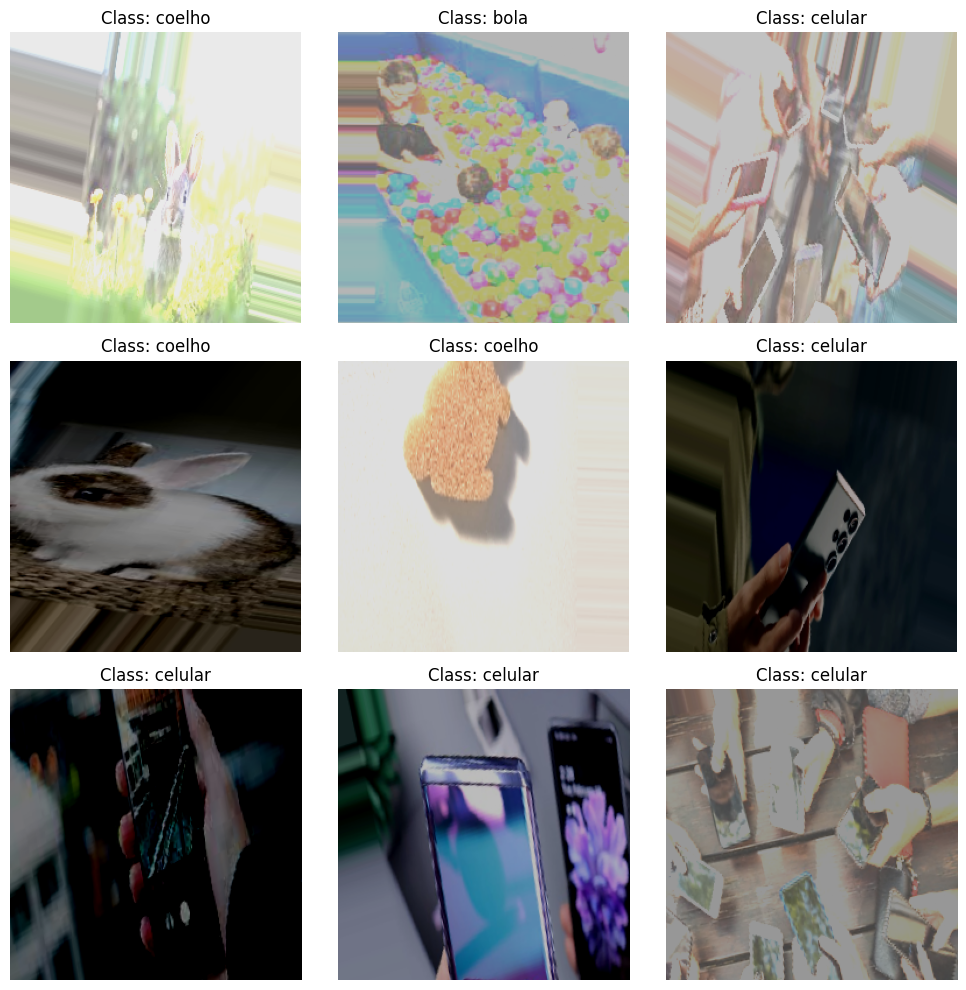

In [6]:
# Carregando imagens
images, labels = next(train_generator)
    
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(f'Class: {classes[label]}')  # Exibir a classe binária (0 ou 1)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Modelo CNN

In [15]:
# Modelo CNN
model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', name=LAST_CONV_NAME_LAYER))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 256)     7168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 124, 124, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 256)     590080    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 61, 61, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 59, 59, 128)       295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 29, 29, 128)     

In [16]:
#Callback to save the best model 
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model-cnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE,verbose=1)
]

#Training
history = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks = callbacks_list,
            validation_data=validation_generator,
            verbose = 1,
            validation_steps=nb_validation_samples // BATCH_SIZE
        )

Epoch 1/1200
11/11 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.3584
Epoch 1: val_loss improved from inf to 1.09908, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 44s 2s/step - loss: 1.1495 - accuracy: 0.3584 - val_loss: 1.0991 - val_accuracy: 0.3375
Epoch 2/1200
11/11 [==============================] - ETA: 0s - loss: 1.1016 - accuracy: 0.3526
Epoch 2: val_loss improved from 1.09908 to 1.09466, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 643ms/step - loss: 1.1016 - accuracy: 0.3526 - val_loss: 1.0947 - val_accuracy: 0.3375
Epoch 3/1200
11/11 [==============================] - ETA: 0s - loss: 1.1076 - accuracy: 0.3636
Epoch 3: val_loss improved from 1.09466 to 1.03861, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 670ms/step - loss: 1.1076 - accuracy: 0.3636 - val_loss: 1.0386 - val_accuracy: 0.3375
Epoch 4/1200
11/11 [==============================] - ETA: 0s - loss: 1.0569 - accuracy: 0.3920
Epoch 4: val_loss improved from 1.03861 to 0.98198, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 696ms/step - loss: 1.0569 - accuracy: 0.3920 - val_loss: 0.9820 - val_accuracy: 0.5250
Epoch 5/1200
11/11 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.4682
Epoch 5: val_loss improved from 0.98198 to 0.95840, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 664ms/step - loss: 1.0556 - accuracy: 0.4682 - val_loss: 0.9584 - val_accuracy: 0.5625
Epoch 6/1200
11/11 [==============================] - ETA: 0s - loss: 1.0432 - accuracy: 0.4740
Epoch 6: val_loss improved from 0.95840 to 0.93932, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 656ms/step - loss: 1.0432 - accuracy: 0.4740 - val_loss: 0.9393 - val_accuracy: 0.6250
Epoch 7/1200
11/11 [==============================] - ETA: 0s - loss: 1.0765 - accuracy: 0.4740
Epoch 7: val_loss did not improve from 0.93932
11/11 [==============================] - 5s 451ms/step - loss: 1.0765 - accuracy: 0.4740 - val_loss: 1.0403 - val_accuracy: 0.4125
Epoch 8/1200
11/11 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.4335
Epoch 8: val_loss improved from 0.93932 to 0.91800, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 682ms/step - loss: 1.0556 - accuracy: 0.4335 - val_loss: 0.9180 - val_accuracy: 0.5625
Epoch 9/1200
11/11 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.5087
Epoch 9: val_loss improved from 0.91800 to 0.89052, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 646ms/step - loss: 1.0144 - accuracy: 0.5087 - val_loss: 0.8905 - val_accuracy: 0.5500
Epoch 10/1200
11/11 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.5087
Epoch 10: val_loss did not improve from 0.89052
11/11 [==============================] - 5s 449ms/step - loss: 0.9882 - accuracy: 0.5087 - val_loss: 0.8909 - val_accuracy: 0.5750
Epoch 11/1200
11/11 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.4943
Epoch 11: val_loss did not improve from 0.89052
11/11 [==============================] - 5s 453ms/step - loss: 0.9842 - accuracy: 0.4943 - val_loss: 0.9055 - val_accuracy: 0.5625
Epoch 12/1200
11/11 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.5260
Epoch 12: val_loss improved from 0.89052 to 0.88573, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 653ms/step - loss: 0.9902 - accuracy: 0.5260 - val_loss: 0.8857 - val_accuracy: 0.6250
Epoch 13/1200
11/11 [==============================] - ETA: 0s - loss: 1.0177 - accuracy: 0.4855
Epoch 13: val_loss did not improve from 0.88573
11/11 [==============================] - 5s 451ms/step - loss: 1.0177 - accuracy: 0.4855 - val_loss: 0.8954 - val_accuracy: 0.5500
Epoch 14/1200
11/11 [==============================] - ETA: 0s - loss: 0.9841 - accuracy: 0.5029
Epoch 14: val_loss improved from 0.88573 to 0.87272, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 705ms/step - loss: 0.9841 - accuracy: 0.5029 - val_loss: 0.8727 - val_accuracy: 0.5625
Epoch 15/1200
11/11 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.5838
Epoch 15: val_loss improved from 0.87272 to 0.85601, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 643ms/step - loss: 0.8798 - accuracy: 0.5838 - val_loss: 0.8560 - val_accuracy: 0.5250
Epoch 16/1200
11/11 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.5665
Epoch 16: val_loss did not improve from 0.85601
11/11 [==============================] - 5s 462ms/step - loss: 0.8869 - accuracy: 0.5665 - val_loss: 2.0682 - val_accuracy: 0.3375
Epoch 17/1200
11/11 [==============================] - ETA: 0s - loss: 1.0724 - accuracy: 0.5202
Epoch 17: val_loss did not improve from 0.85601
11/11 [==============================] - 5s 461ms/step - loss: 1.0724 - accuracy: 0.5202 - val_loss: 0.9412 - val_accuracy: 0.4625
Epoch 18/1200
11/11 [==============================] - ETA: 0s - loss: 0.9374 - accuracy: 0.5087
Epoch 18: val_loss did not improve from 0.85601
11/11 [==============================] - 5s 463ms/step - loss: 0.9374 - accuracy: 0.5087 - val_loss: 0.8897 - val_accuracy: 0.5875
Epoch 19/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 662ms/step - loss: 0.8729 - accuracy: 0.5549 - val_loss: 0.8512 - val_accuracy: 0.5875
Epoch 21/1200
11/11 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.6185
Epoch 21: val_loss did not improve from 0.85120
11/11 [==============================] - 5s 452ms/step - loss: 0.8873 - accuracy: 0.6185 - val_loss: 0.8787 - val_accuracy: 0.5375
Epoch 22/1200
11/11 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.6127
Epoch 22: val_loss did not improve from 0.85120
11/11 [==============================] - 5s 454ms/step - loss: 0.8702 - accuracy: 0.6127 - val_loss: 0.8640 - val_accuracy: 0.6375
Epoch 23/1200
11/11 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.5665
Epoch 23: val_loss did not improve from 0.85120
11/11 [==============================] - 5s 452ms/step - loss: 0.9625 - accuracy: 0.5665 - val_loss: 1.0403 - val_accuracy: 0.4750
Epoch 24/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 681ms/step - loss: 0.8965 - accuracy: 0.5682 - val_loss: 0.8438 - val_accuracy: 0.6500
Epoch 26/1200
11/11 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6705
Epoch 26: val_loss did not improve from 0.84375
11/11 [==============================] - 5s 453ms/step - loss: 0.8412 - accuracy: 0.6705 - val_loss: 1.0663 - val_accuracy: 0.5250
Epoch 27/1200
11/11 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6532
Epoch 27: val_loss did not improve from 0.84375
11/11 [==============================] - 5s 442ms/step - loss: 0.8241 - accuracy: 0.6532 - val_loss: 1.0216 - val_accuracy: 0.5750
Epoch 28/1200
11/11 [==============================] - ETA: 0s - loss: 0.8848 - accuracy: 0.6358
Epoch 28: val_loss did not improve from 0.84375
11/11 [==============================] - 5s 455ms/step - loss: 0.8848 - accuracy: 0.6358 - val_loss: 0.9733 - val_accuracy: 0.5250
Epoch 29/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 673ms/step - loss: 0.8364 - accuracy: 0.6532 - val_loss: 0.8003 - val_accuracy: 0.6625
Epoch 32/1200
11/11 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.7110
Epoch 32: val_loss did not improve from 0.80032
11/11 [==============================] - 6s 472ms/step - loss: 0.7458 - accuracy: 0.7110 - val_loss: 0.8754 - val_accuracy: 0.6875
Epoch 33/1200
11/11 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.6936
Epoch 33: val_loss improved from 0.80032 to 0.79818, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 8s 746ms/step - loss: 0.8054 - accuracy: 0.6936 - val_loss: 0.7982 - val_accuracy: 0.6375
Epoch 34/1200
11/11 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.6879
Epoch 34: val_loss did not improve from 0.79818
11/11 [==============================] - 6s 464ms/step - loss: 0.7682 - accuracy: 0.6879 - val_loss: 0.9396 - val_accuracy: 0.5000
Epoch 35/1200
11/11 [==============================] - ETA: 0s - loss: 0.8036 - accuracy: 0.6534
Epoch 35: val_loss did not improve from 0.79818
11/11 [==============================] - 5s 455ms/step - loss: 0.8036 - accuracy: 0.6534 - val_loss: 0.9349 - val_accuracy: 0.4750
Epoch 36/1200
11/11 [==============================] - ETA: 0s - loss: 0.8485 - accuracy: 0.6416
Epoch 36: val_loss did not improve from 0.79818
11/11 [==============================] - 5s 448ms/step - loss: 0.8485 - accuracy: 0.6416 - val_loss: 0.8099 - val_accuracy: 0.6000
Epoch 37/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 659ms/step - loss: 0.7921 - accuracy: 0.6879 - val_loss: 0.7413 - val_accuracy: 0.6500
Epoch 42/1200
11/11 [==============================] - ETA: 0s - loss: 0.7992 - accuracy: 0.6647
Epoch 42: val_loss did not improve from 0.74133
11/11 [==============================] - 5s 463ms/step - loss: 0.7992 - accuracy: 0.6647 - val_loss: 0.7643 - val_accuracy: 0.6625
Epoch 43/1200
11/11 [==============================] - ETA: 0s - loss: 0.9048 - accuracy: 0.5723
Epoch 43: val_loss did not improve from 0.74133
11/11 [==============================] - 5s 465ms/step - loss: 0.9048 - accuracy: 0.5723 - val_loss: 0.9583 - val_accuracy: 0.5500
Epoch 44/1200
11/11 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.5954
Epoch 44: val_loss did not improve from 0.74133
11/11 [==============================] - 5s 456ms/step - loss: 0.8297 - accuracy: 0.5954 - val_loss: 0.9816 - val_accuracy: 0.5000
Epoch 45/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 653ms/step - loss: 0.8202 - accuracy: 0.6474 - val_loss: 0.6818 - val_accuracy: 0.7000
Epoch 49/1200
11/11 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7052
Epoch 49: val_loss did not improve from 0.68177
11/11 [==============================] - 6s 479ms/step - loss: 0.7178 - accuracy: 0.7052 - val_loss: 0.8116 - val_accuracy: 0.5875
Epoch 50/1200
11/11 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.6301
Epoch 50: val_loss did not improve from 0.68177
11/11 [==============================] - 5s 464ms/step - loss: 0.7743 - accuracy: 0.6301 - val_loss: 0.9596 - val_accuracy: 0.5375
Epoch 51/1200
11/11 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.6474
Epoch 51: val_loss did not improve from 0.68177
11/11 [==============================] - 5s 453ms/step - loss: 0.8362 - accuracy: 0.6474 - val_loss: 0.7166 - val_accuracy: 0.7250
Epoch 52/1200
11/11 [====================

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


11/11 [==============================] - 7s 672ms/step - loss: 0.6565 - accuracy: 0.7688 - val_loss: 0.6465 - val_accuracy: 0.7625
Epoch 95/1200
11/11 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.6989
Epoch 95: val_loss did not improve from 0.64649
11/11 [==============================] - 6s 472ms/step - loss: 0.7993 - accuracy: 0.6989 - val_loss: 1.0956 - val_accuracy: 0.5625
Epoch 96/1200
11/11 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7225
Epoch 96: val_loss did not improve from 0.64649
11/11 [==============================] - 5s 463ms/step - loss: 0.6639 - accuracy: 0.7225 - val_loss: 0.9089 - val_accuracy: 0.6000
Epoch 97/1200
11/11 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7514
Epoch 97: val_loss did not improve from 0.64649
11/11 [==============================] - 5s 450ms/step - loss: 0.6246 - accuracy: 0.7514 - val_loss: 0.8430 - val_accuracy: 0.6375
Epoch 98/1200
11/11 [====================

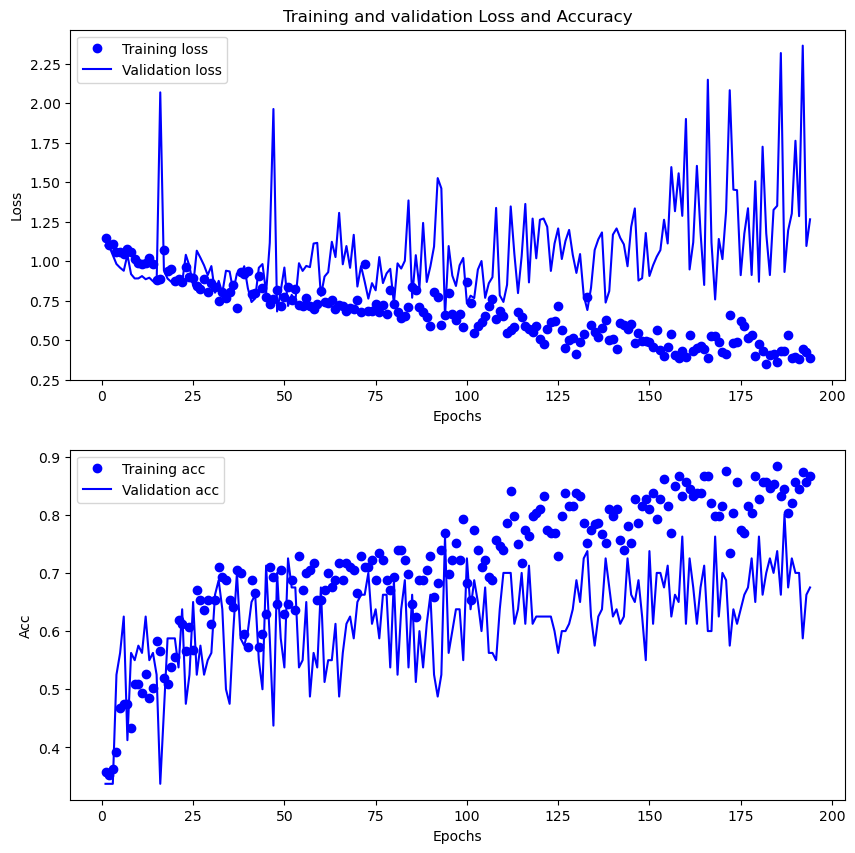

In [17]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Avaliando Modelo CNN

In [22]:
# Load the best saved model
from tensorflow.keras.models import load_model

# model = load_model('model-cnn.h5')
model = load_model('./best_result/model-cnn.h5')

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 256)     7168      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 124, 124, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 256)     590080    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 61, 61, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 59, 59, 128)       295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 29, 29, 128)     

In [24]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

5/5 [==============================] - 3s 55ms/step - loss: 0.6423 - accuracy: 0.7875
Val loss: 0.6422817707061768
Val accuracy: 0.7875000238418579


In [25]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 2s 191ms/step - loss: 0.5854 - accuracy: 0.8151
Test loss: 0.5854089856147766
Test accuracy: 0.8151260614395142


8/8 [==============================] - 1s 140ms/step
Classification Report
              precision    recall  f1-score   support

        bola       0.88      0.70      0.78        40
     celular       0.71      0.97      0.82        40
      coelho       0.91      0.74      0.82        39

    accuracy                           0.81       119
   macro avg       0.83      0.81      0.81       119
weighted avg       0.83      0.81      0.81       119



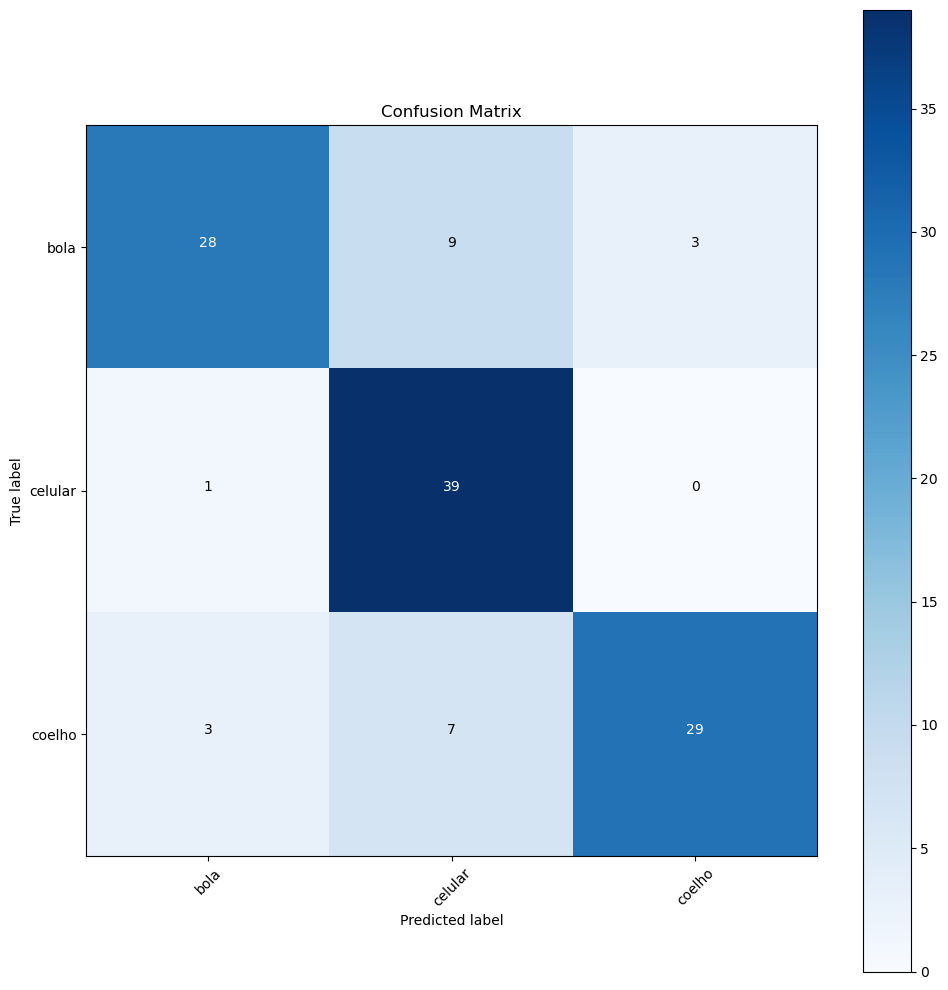

In [40]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
#On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Modelo com Transfer Learning

In [11]:
# Modelo Transfer Learning
base_model = Xception(weights='imagenet',include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform' )(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
base_model.trainable = False

model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
  

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [12]:
#Callback to save the best model 
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model-tf.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE,verbose=1)
]

#Training
history = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks = callbacks_list,
            validation_data=validation_generator,
            verbose = 1,
            validation_steps=nb_validation_samples // BATCH_SIZE
        )

Epoch 1/1200
11/11 [==============================] - ETA: 0s - loss: 1.0660 - accuracy: 0.4624
Epoch 1: val_loss improved from inf to 0.56199, saving model to model-tf.h5
11/11 [==============================] - 11s 799ms/step - loss: 1.0660 - accuracy: 0.4624 - val_loss: 0.5620 - val_accuracy: 0.7750
Epoch 2/1200
11/11 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.6936
Epoch 2: val_loss improved from 0.56199 to 0.22928, saving model to model-tf.h5
11/11 [==============================] - 14s 1s/step - loss: 0.8551 - accuracy: 0.6936 - val_loss: 0.2293 - val_accuracy: 0.9250
Epoch 3/1200
11/11 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8382
Epoch 3: val_loss improved from 0.22928 to 0.05473, saving model to model-tf.h5
11/11 [==============================] - 8s 684ms/step - loss: 0.3809 - accuracy: 0.8382 - val_loss: 0.0547 - val_accuracy: 0.9875
Epoch 4/1200
11/11 [==============================] - ETA: 0s - loss: 0.4253 - accur

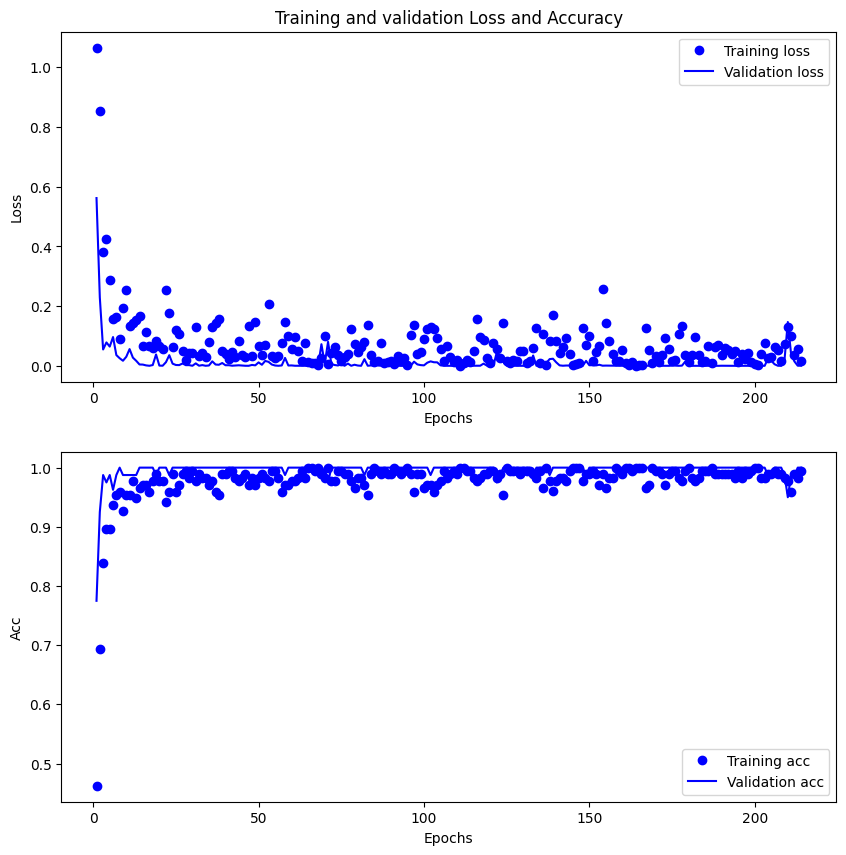

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Avaliando Modelo com Transfer Learning Xception

In [28]:
# Load the best saved model
model = load_model('./best_result/model-tf.h5')
# model = load_model('model-tf.h5')

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [29]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

5/5 [==============================] - 1s 59ms/step - loss: 4.4703e-09 - accuracy: 1.0000
Val loss: 4.470348091700771e-09
Val accuracy: 1.0


In [30]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 1s 84ms/step - loss: 0.2019 - accuracy: 0.9916
Test loss: 0.20191696286201477
Test accuracy: 0.9915966391563416


C:\Users\PC\AppData\Local\Temp\ipykernel_1788\633595769.py:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)


Classification Report
              precision    recall  f1-score   support

        bola       0.98      1.00      0.99        40
     celular       1.00      1.00      1.00        40
      coelho       1.00      0.97      0.99        39

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119



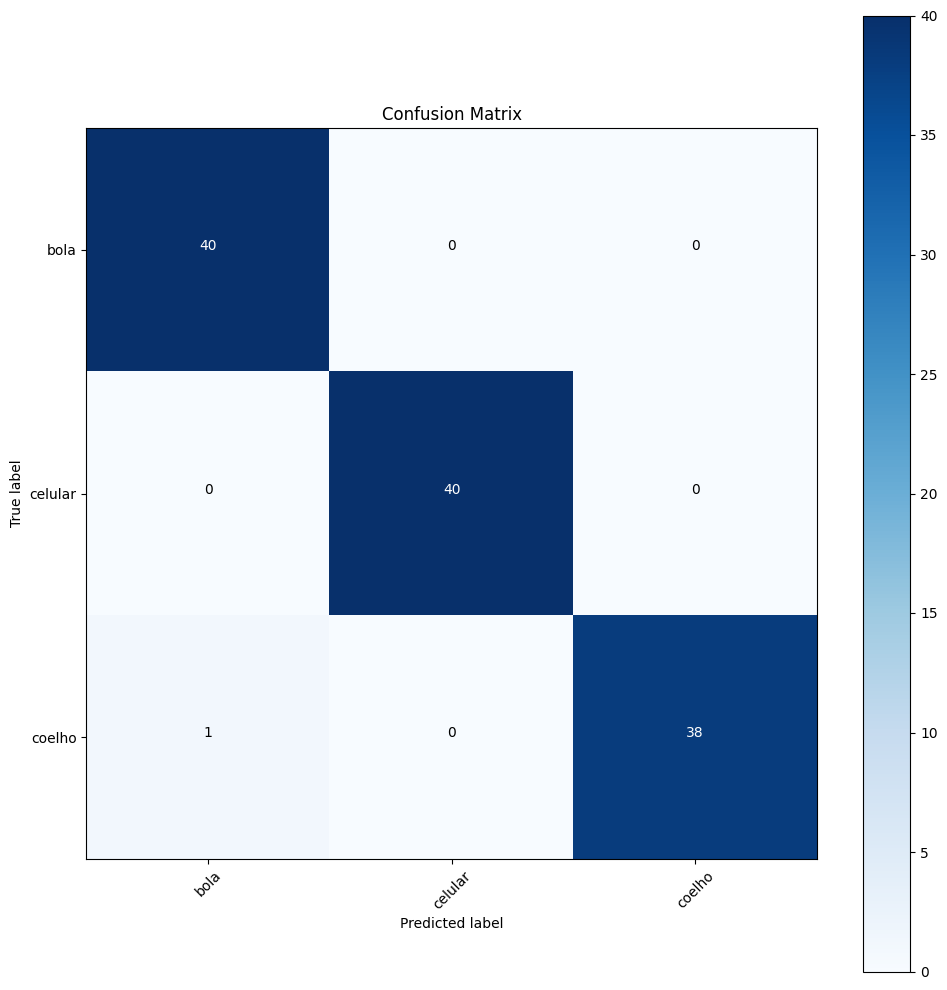

In [18]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Comparação de Modelos: CNN X Transfer Learning(Xception)

# Uso do modelo com câmera

In [20]:
# Função para calcular o Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Calcular os gradientes da predição
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradientes da classe com relação às ativações da última camada convolucional
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Media dos gradientes para cada filtro
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar cada canal na feature map pelo gradiente médio
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizar o heatmap entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Função para sobrepor o heatmap na imagem
def superimpose_heatmap(heatmap, img, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
    # Converta img (que está em formato float32) de volta para uint8
    if img.dtype != np.uint8:
        img = np.uint8(255 * img)  # Escalar de 0-1 para 0-255
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img

# Process image
def process_image(frame, input_shape):
    # Pre-processamento da imagem
    img = cv2.resize(frame, input_shape)
    img = img.astype('float32') / 255.0  # Normaliza para 0-1
    img = np.expand_dims(img, axis=0)    # Adiciona dimensão de lote (batch)

    # Fazer previsão com o modelo
    prediction = model.predict(img)
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)
    
    # Nome da última camada convolucional do seu modelo
    # last_conv_layer_name = LAST_CONV_NAME_LAYER # Usar para CNN
    last_conv_layer_name = LAST_CONV_NAME_LAYER_TF # Usar para Transfer Learning
    

    # Gerar o heatmap Grad-CAM
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

    # Converta a imagem do formato de tensor de volta para RGB uint8 para sobreposição
    img_rgb = frame.astype('float32') / 255.0  # Normalizar
    superimposed_img = superimpose_heatmap(heatmap, img_rgb)

    # Exibir o resultado no frame
    cv2.putText(frame, f'Class: {labels_prediction[predicted_class[0]]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Exibir o frame
    cv2.imshow('Camera', frame)
    cv2.imshow('Heatmap', superimposed_img)

In [21]:
# Parâmetros
input_shape = im_shape

# Iniciar a captura da câmera
cap = cv2.VideoCapture(0)  # '0' geralmente é a câmera padrão. Pode ser ajustado para outra fonte.
cap.set(cv2.CAP_PROP_FPS, 10)
while True:
    # Captura frame a frame
    ret, frame = cap.read()
    if not ret:
        break

    process_image(frame, input_shape)

    # Sair com a tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libere a captura e feche as janelas
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 804ms/step
[[0.43645638 0.3307247  0.2328189 ]]
1/1 [==============================] - 0s 25ms/step
[[0.7535619  0.15434705 0.09209111]]
1/1 [==============================] - 0s 24ms/step
[[0.6859638 0.1972793 0.1167569]]
1/1 [==============================] - 0s 22ms/step
[[0.6031042  0.24503374 0.15186211]]
1/1 [==============================] - 0s 27ms/step
[[0.5864342  0.25215462 0.16141117]]
1/1 [==============================] - 0s 23ms/step
[[0.7382003  0.16627955 0.09552014]]
1/1 [==============================] - 0s 22ms/step
[[0.7891951 0.1336598 0.0771451]]
1/1 [==============================] - 0s 23ms/step
[[0.8010365  0.12729746 0.07166598]]
1/1 [==============================] - 0s 23ms/step
[[0.7736837  0.14356199 0.08275426]]
1/1 [==============================] - 0s 23ms/step
[[0.7754266  0.14281416 0.08175922]]
1/1 [==============================] - 0s 24ms/step
[[0.7876334  0.13557476 0.0767918 ]]
1/1 [=====================